
## Sesión 4.Introducción al Aprendizaje por Refuerzo en entornos continuos discretizados. 
#### Inteligencia Artificial 2024 / 25
##### Belén Díaz Agudo 

En la parte 1 hemos trabado con dominios discretos. 
El dominio Cart-Pole es un ejemplo de dominio continuo en el que  tenemos un poste que está unido por una articulación no accionada a un carro, que se mueve a lo largo de una pista sin fricción. El sistema se controla aplicando una fuerza de +1 o -1 al carro. El péndulo comienza en posición vertical y el objetivo es evitar que se caiga. Se proporciona una recompensa de +1 por cada paso de tiempo que el poste permanece en posición vertical. El episodio termina cuando el poste está a más de 15 grados de la vertical o el carro se mueve más de 2.4 unidades desde el centro.



https://gymnasium.farama.org/environments/classic_control/cart_pole/


In [5]:
import gymnasium as gym

In [ ]:
# Generamos el entorno CartPole v1 y realizamos acciones aleatorias 
env = gym.make('CartPole-v1', render_mode="human")
for i_episode in range(20):
    observation,_ = env.reset()
    for t in range(100):
        env.render()
        print(observation)
        action = env.action_space.sample()
        observation, reward, done, info,_ = env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
env.close()

#### Documentación del problema
    Description:
        A pole is attached by an un-actuated joint to a cart, which moves along
        a frictionless track. The pendulum starts upright, and the goal is to
        prevent it from falling over by increasing and reducing the cart's
        velocity.
    Source:
        This environment corresponds to the version of the cart-pole problem
        described by Barto, Sutton, and Anderson
    Observation:
        Type: Box(4)
        Num     Observation               Min                     Max
        0       Cart Position             -4.8                    4.8
        1       Cart Velocity             -Inf                    Inf
        2       Pole Angle                -0.418 rad (-24 deg)    0.418 rad (24 deg)
        3       Pole Angular Velocity     -Inf                    Inf
    Actions:
        Type: Discrete(2)
        Num   Action
        0     Push cart to the left
        1     Push cart to the right
        Note: The amount the velocity that is reduced or increased is not
        fixed; it depends on the angle the pole is pointing. This is because
        the center of gravity of the pole increases the amount of energy needed
        to move the cart underneath it
    Reward:
        Reward is 1 for every step taken, including the termination step
    Starting State:
        All observations are assigned a uniform random value in [-0.05..0.05]
    Episode Termination:
        Pole Angle is more than 12 degrees.
        Cart Position is more than 2.4 (center of the cart reaches the edge of
        the display).
        Episode length is greater than 200.
        Solved Requirements:
        Considered solved when the average return is greater than or equal to
        195.0 over 100 consecutive trials.


# Entender el entorno
https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py

In [11]:
env = gym.make('CartPole-v1')
env.action_space


Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)

In [ ]:
env.observation_space

In [9]:
env.action_space.sample()

0

In [13]:
env.observation_space.sample()

array([-3.6905270e+00, -1.7117548e+38,  2.9353103e-01, -8.9056359e+36],
      dtype=float32)

In [ ]:
import numpy as np
import gym
import random
from IPython.display import clear_output

class QLearnAgent():
    def __init__(self, number_bins = (20,20,20,20)):
        bounds = (4.8, 4, .418, 4)
        self.bins = [ np.linspace(-1*bound, bound, numBins) for (bound, numBins) in zip(bounds, number_bins)]
        
        self.q_table = np.random.uniform(low=-2, high=0, size=[*number_bins, 2])
        self.env = gym.make('CartPole-v1')
        
    def discretize(self, obs):
        return tuple(np.digitize(obs_data, bins)-1 for (obs_data, bins) in zip(obs, self.bins))
    
    def fill_table(self, alpha = 0.75, gamma = 0.75, epsilon = 1, total_episodes=10000, info_control_time=100):
        info = {"step": [], "avg": []}
        
        env = self.env
        reduce_epsilon_start = 1
        reduce_epsilon_end = total_episodes // 2
        reduce_epsilon_value = epsilon / (reduce_epsilon_end - reduce_epsilon_start)
        
        previous = []
        q_table = self.q_table
        for i in range(1, total_episodes):            
            done = False
            discrete_state = self.discretize(env.reset())
            steps = 0
            while not done:
                steps += 1
                if random.random() < epsilon:
                    action = env.action_space.sample() # Explore action space
                else:
                    action = np.argmax(q_table[discrete_state])

                next_state, reward, done, _ = env.step(action) 
                next_discrete_state = self.discretize(next_state)
                
                next_max = np.max(q_table[next_discrete_state])
                old_value = q_table[discrete_state + (action,)]
            
                if done and steps < 200:
                    reward = -375

                new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
                q_table[discrete_state + (action,)] = new_value
                discrete_state = next_discrete_state
                
            previous.append(steps)
                
            if i % info_control_time == 0:
                clear_output(wait=True)
                print(f"Episode: {i}")
                latest = previous [-info_control_time:]
                info["step"].append(i)
                info["avg"].append(sum(latest)/len(latest))
                
            if reduce_epsilon_end >= i >= reduce_epsilon_start:
                epsilon -= reduce_epsilon_value
        
        return info


In [ ]:
q = QLearnAgent()
info = q.fill_table(alpha = 0.75, gamma = 0.75, epsilon = 1, total_episodes = 1500)


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

fig, ax = plt.subplots(1)
fig.set_size_inches(12.5, 8.5, forward=True)
ax.plot(info["step"], info["avg"])
ax.set_xlabel("Iteraciones de entrenamiento", size = 13)
ax.set_ylabel("Timesteps medios", size = 13)
ax.set_title(r"Comportamiento del agente" + "\n"
             r"($\alpha = 0.75$, $\gamma=0.75$, $\epsilon=1$)", size=15)

In [ ]:
import math
import numpy as np
alpha_distinct = 5
epsilon_distinct = 5
gamma_distinct = 5

alphas, epsilons, gammas = np.linspace(0, 1, alpha_distinct), np.linspace(0,1,epsilon_distinct),\
    np.linspace(0,1, gamma_distinct)


total_episodes = 1001
info_control_time = 100
data_points = math.ceil(total_episodes/info_control_time)
metric = np.zeros([alpha_distinct, epsilon_distinct, gamma_distinct, data_points])
for alpha in alphas:
    alpha_i = np.digitize(alpha, alphas)-1
    for epsilon in epsilons:
        epsilon_i = np.digitize(epsilon, epsilons)-1
        for gamma in gammas:
            gamma_i = np.digitize(gamma, gammas)-1

            q = QLearnAgent()
            info = q.fill_table(alpha=alpha, epsilon=epsilon, gamma=gamma,
                                total_episodes = total_episodes, info_control_time = info_control_time)
            for (step, avg) in zip(info["step"], info["avg"]):
                metric[alpha_i, epsilon_i, gamma_i, step//info_control_time] = avg
            


In [ ]:
def get_series(alpha, epsilon, gamma):
    alpha_i, epsilon_i, gamma_i = np.digitize(alpha, alphas)-1, np.digitize(epsilon, epsilons)-1,\
        np.digitize(gamma, gammas)-1

    return metric[alpha_i, epsilon_i, gamma_i]



x_axis = np.arange(0, total_episodes, info_control_time)

fig, ax = plt.subplots(3)
fig.tight_layout(pad=0.5)
fig.set_size_inches(18.5, 10.5, forward=True)
#Variacion de alpha
alphas_plots = [alphas, [0.75], [0.75]]
epsilon_plots = [[1], epsilons, [1]]
gammas_plots = [[0.75], [0.75], gammas]

for i in range(0,3):
    current_axis = ax[i]
    for alpha in alphas_plots[i]:
        alpha_i = np.digitize(alpha, alphas)-1
        for epsilon in epsilon_plots[i]:
            epsilon_i = np.digitize(epsilon, epsilons)-1
            for gamma in gammas_plots[i]:
                gamma_i = np.digitize(gamma, gammas)-1
                if i == 0:
                    titulo = f"Variación de $\\alpha \\ (\\epsilon = {{{epsilon}}}, \\gamma={{{gamma}}})$"
                    current_label = f"$\\alpha: {{{alpha}}}$"
                elif i == 1:
                    titulo = f"Variación de $\\epsilon \\ (\\alpha = {{{alpha}}}, \\gamma={{{gamma}}})$"
                    current_label = f"$\\epsilon={{{epsilon}}}$"
                else:
                    titulo = f"Variación de $\\gamma \\ (\\alpha = {{{alpha}}}, \\epsilon={{{epsilon}}})$"
                    current_label = f"$\\gamma={{{gamma}}}$"
                current_axis.plot(x_axis, get_series(alpha, epsilon,gamma), label=current_label)
                current_axis.legend()
                current_axis.set_title(titulo, size = 15)
                current_axis.set_ylabel("Número medio de timesteps", size = 13)
                current_axis.set_xlabel("Iteraciones de entrenamiento", size = 13)
plt.show()


El agente realizado se ha implementado como la clase QLearnAgent. 
El estado del problema tiene 4 valores variables:
- La posición del carro (entre -4.8 y 4.8)
- La velocidad del carro (entre -infinito y +infinito)
- El ángulo que forma el poste respecto al carro (entre -0.418 y 0.418 radianes)
- La velocidad angular del poste (entre -infinito y +infinito)
Todas las variables son continuas y la segunda y la cuarta son no acotadas, con lo que es necesario discretizar el espacio de estados. Para ello, hemos dividido el dominio de cada variable en 20 intervalos. El usuario puede configurar el número de intervalos usados para cada variable mediante el parámetro number_bins. 

El método discretize de la clase QLearnAgent permite determinar en qué intervalo se encuentra cada una de las variables asociadas al estado; de cara al aprendizaje automático todos los valores de un determinado intervalo son idénticos y son tratados de forma homogénea. Aumentar el número de intervalos en los que está dividida cada variable aumenta la precisión del aprendizaje pero también la dimensión del espacio de estados.

Aplicado de esta forma, se puede observar, por ejemplo, que el método de Q-Learning entrenado con 10.000 iteraciones (con hiperparámetros $\alpha = 0.75$, $\gamma = 0.75$, $\epsilon = 1$) el agente conseguía mantener el poste en posición alrededor de 430 *timesteps*, 21 veces más que el comportamiento aleatorio. 

##### Hiperparámetros
Observa en las gráficas el efecto de variar los hiperparámetros en los resultados y en el tiempo de entrenamiento y cual sería la mejor elección de parámetros. 




#### Gráfica de ejemplo que muestra la variación de los hiperparámetros. Genera tus propias gráficas para estudiar el comportamiento y coméntalo.
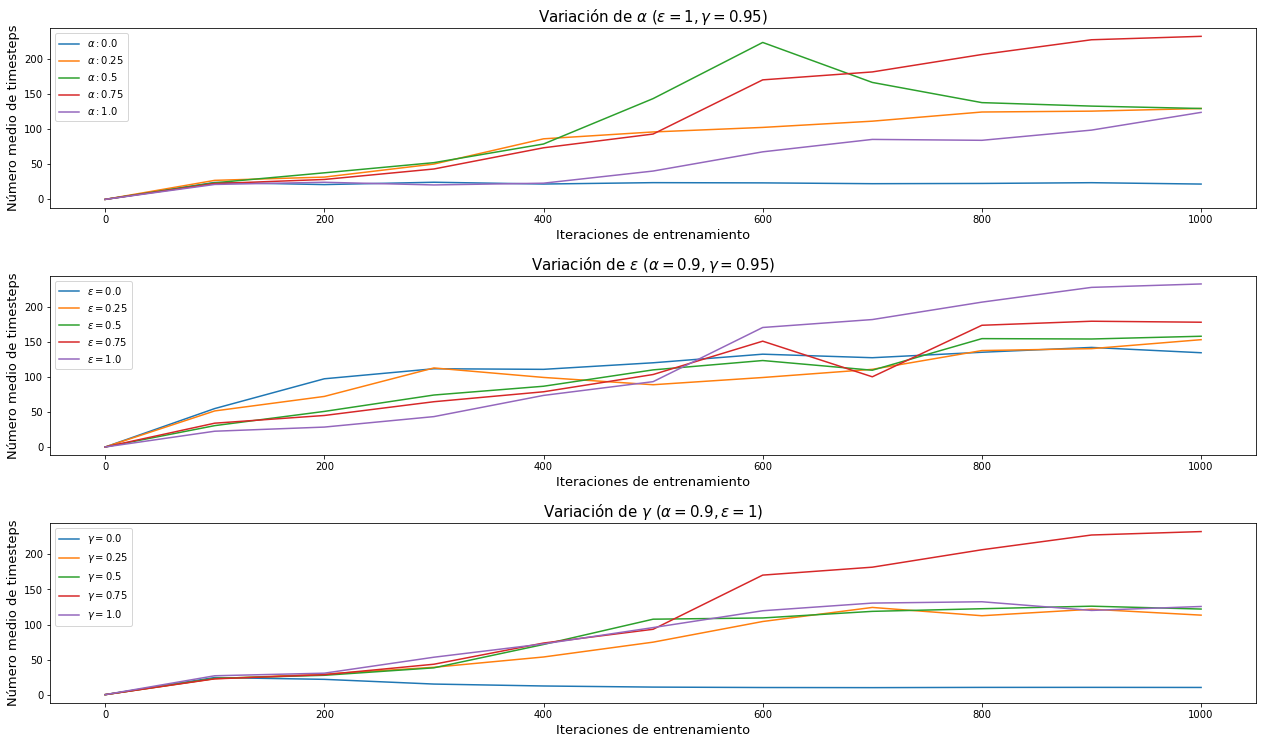

#### Otro ejemplo de gráfico para ver el efecto de la variación de los hiperparámetros
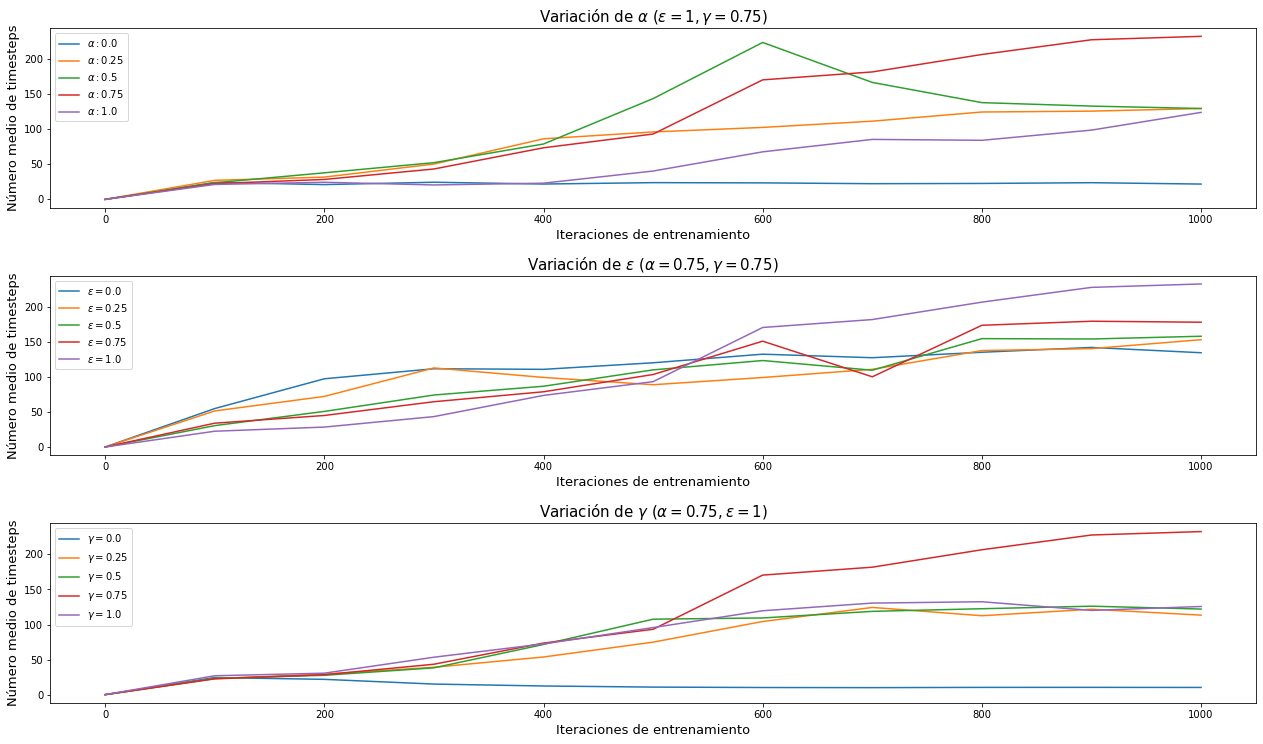